# Expected loss
# EL = PD x LGD x EAD

In [52]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stat
pd.options.display.max_rows = None

In [53]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [54]:
loan_data_preprocessed = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_8956\1254568773.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')


In [55]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,0,1,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,0,1,0
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,0,1,0
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,0,1,0


In [56]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [57]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [58]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [59]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [60]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [61]:
# loading the models
log_reg_pd_model = pickle.load(open('pd_model.sav', 'rb'))
beta_reg_ead_model = pickle.load(open('ead_betareg_model.sav', 'rb'))
log_reg_lgd_stage_1_model = pickle.load(open('lgd_stage_1_model.sav', 'rb'))
beta_reg_lgd_stage_2_model = pickle.load(open('lgd_stage_2_betareg_model.sav', 'rb'))

In [62]:
# LGD = 1 - recovery rate

In [63]:
# stage 1 lgd on all the data
loan_data_preprocessed['recovery_rate_st_1'] = log_reg_lgd_stage_1_model.model.predict(loan_data_preprocessed_lgd_ead)

In [64]:
loan_data_preprocessed['recovery_rate_st_2'] = beta_reg_lgd_stage_2_model.predict(sm.add_constant(loan_data_preprocessed_lgd_ead.values))

In [65]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [66]:
# if we use linear regression instead of beta regression we have to set > 1 = 0 and < 0 = 0
#loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
#loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [67]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

<AxesSubplot: >

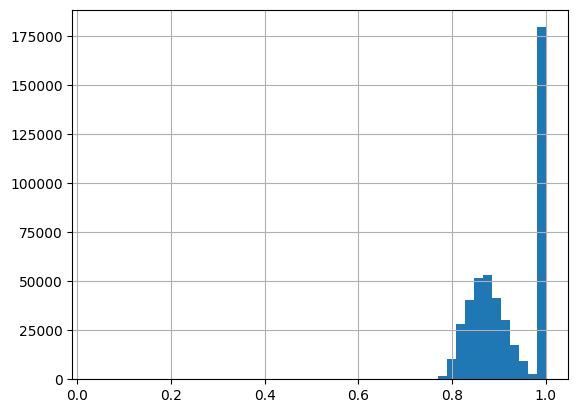

In [68]:
loan_data_preprocessed['LGD'].hist(bins=50)

In [69]:
loan_data_preprocessed['CCF'] = beta_reg_ead_model.predict(sm.add_constant(loan_data_preprocessed_lgd_ead.values))

In [70]:
# if we use linear regression instead of beta regression we have to set > 1 = 0 and < 0 = 0
#loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
#loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [71]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

<AxesSubplot: >

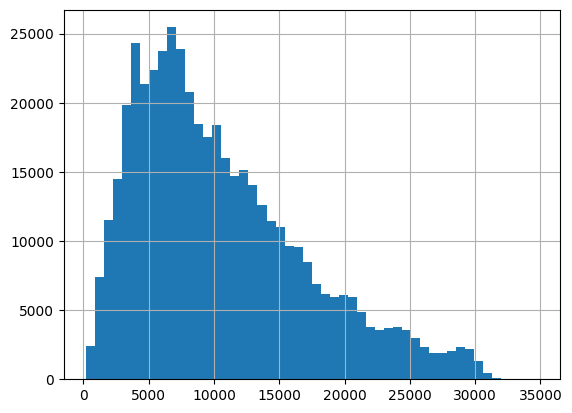

In [72]:
loan_data_preprocessed['EAD'].hist(bins=50)

In [73]:
loan_data_inputs_train = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_inputs_train.csv', index_col=0)
loan_data_inputs_test = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_inputs_test.csv', index_col=0)

In [74]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis=0)

In [75]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
403678,403678,403678,14560583,16622883,24000,24000,24000.0,60 months,11.99,533.75,...,0,0,0,1,0,0,0,0,0,0
241492,241492,241492,34303344,36966688,30000,30000,30000.0,60 months,12.39,673.27,...,0,0,0,1,0,0,0,0,0,0
15864,15864,15864,737124,934233,2400,2400,2400.0,36 months,13.49,81.44,...,0,0,0,1,0,0,0,0,0,0
320277,320277,320277,25326009,27668971,12000,12000,12000.0,36 months,13.98,410.02,...,0,0,0,1,0,0,0,0,0,0
299829,299829,299829,28633305,31166460,5000,5000,5000.0,36 months,11.67,165.29,...,0,0,0,0,0,0,0,0,1,0


In [76]:
# removing one dummy variable for k-1
ref_categories = ['grade:G',
                'home_ownership:RENT_OTHER_NONE_ANY',
                'addr_state:ND_NE_IA_NV_HI_FL_AL',
                'verification_status:Verified',
                'purpose:edu_sb_re_m_h_other',
                 'initial_list_status:f',
                 'term:60',
                 'emp_length:0',
                 'mths_since_issue_d:>84',
                 'int_rate:>20.281',
                 'mths_since_earliest_cr_line:<142',
                 'delinq_2yrs:>=4',
                 'inq_last_6mths:>6',
                 'open_acc:0',
                 'pub_rec:>=5',
                 'total_acc:<=25',
                 'acc_now_delinq:>=1',
                 'total_rev_hi_lim<=5K',
                 'annual_inc:<20K',
                 'mths_since_last_delinq:Missing',
                 'dti>35',
                 'mths_since_last_record:Missing']

In [77]:
loan_data_inputs_pd = loan_data_inputs_pd.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ME_DC_WY_WV_VT_MS',
'addr_state:NY',
'addr_state:RI_NM_NC_OK_SD_VA_LA',
'addr_state:MD_NJ_MO',
'addr_state:CA',
'addr_state:ID_TN',
'addr_state:AZ_MI_UT_AR_PA_OH_MN_IN',
'addr_state:KY_MA_GA_WA_WI_DE',
'addr_state:OR_IL',
'addr_state:TX',
'addr_state:CT_SC_AK',
'addr_state:KS_CO_MT_NH',
'verification_status:Verified',
'verification_status:Source Verified',
'verification_status:Not Verified',
'purpose:edu_sb_re_m_h_other',
'purpose:med_wed_vac',
'purpose:debt_consolidation',
'purpose:hi_mp_car',
'purpose:credit_card',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:<40-41',
'mths_since_issue_d:<42-48',
'mths_since_issue_d:<49-52',
'mths_since_issue_d:<53-64',
'mths_since_issue_d:<65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<142',
'mths_since_earliest_cr_line:142-266',
'mths_since_earliest_cr_line:266-355',
'mths_since_earliest_cr_line:>355',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
#'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
#'pub_rec:0-2',
#'pub_rec:3-4',
#'pub_rec:>=5',
#'total_acc:<=25',
#'total_acc:25-51',
#'total_acc:>=51',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
#'total_rev_hi_lim:<=5K',
#'total_rev_hi_lim:5K-10K',
#'total_rev_hi_lim:10K-20K',
#'total_rev_hi_lim:20K-30K',
#'total_rev_hi_lim:30K-40K',
#'total_rev_hi_lim:40K-55K',
#'total_rev_hi_lim:55K-95K',
#'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86',
]]

In [78]:
# selecting the desires columns
sel_cols = [c for c in loan_data_inputs_pd.columns if c not in ref_categories]

In [79]:
loan_data_inputs_pd = loan_data_inputs_pd[sel_cols]

In [80]:
loan_data_inputs_pd.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ME_DC_WY_WV_VT_MS,addr_state:NY,...,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
403678,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241492,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15864,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320277,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299829,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [81]:
# probability of default first column, probability of non-default second column
log_reg_pd_model.model.predict_proba(loan_data_inputs_pd)

array([[0.06461286, 0.93538714],
       [0.05015708, 0.94984292],
       [0.17108544, 0.82891456],
       ...,
       [0.03732879, 0.96267121],
       [0.14384913, 0.85615087],
       [0.11516422, 0.88483578]])

In [82]:
loan_data_inputs_pd['PD'] = log_reg_pd_model.model.predict_proba(loan_data_inputs_pd)[:][:, 0]

<AxesSubplot: >

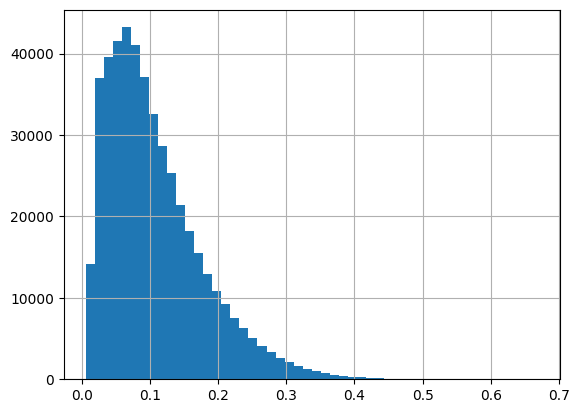

In [83]:
loan_data_inputs_pd['PD'].hist(bins=50)

In [84]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,1,0,1,0.087367,0.087367,0.912633,0.592890,2964.451103
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,1,0,1,0.103414,0.103414,0.896586,0.795263,1988.156940
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,1,0,1,0.095233,0.095233,0.904767,0.694597,1667.032384
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,1,0,1,0.091380,0.091380,0.908620,0.689928,6899.275184
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,1,0,1,0.097864,0.097864,0.902136,0.727165,2181.494698


In [85]:
#loan_data_preprocessed = loan_data_preprocessed.set_index('id')

In [86]:
loan_data_inputs_pd.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ME_DC_WY_WV_VT_MS,addr_state:NY,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86,PD
403678,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.064613
241492,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.050157
15864,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.171085
320277,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.093906
299829,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.054685


In [87]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis=1)

In [88]:
loan_data_preprocessed_new.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86,PD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,0,0,0,0,0,0,0.157531
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,0,0,0.289572
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,0,0,0.210751
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,0,0,0.237587
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,0,0,0.139078


In [91]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

<AxesSubplot: >

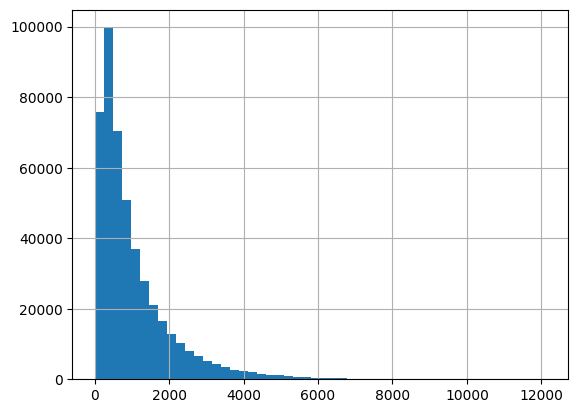

In [92]:
loan_data_preprocessed_new['EL'].hist(bins=50)

In [93]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1038.319725
std        1054.309375
min           9.364000
25%         341.456963
50%         685.050874
75%        1347.305336
max       12116.095028
Name: EL, dtype: float64

In [94]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,PD,LGD,EAD,EL
0,5000,0.157531,0.912633,2964.451103,426.192753
1,2500,0.289572,0.896586,1988.156940,516.176862
2,2400,0.210751,0.904767,1667.032384,317.870757
3,10000,0.237587,0.908620,6899.275184,1489.387957
4,3000,0.139078,0.902136,2181.494698,273.707253


In [96]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

0.07265142595695015